# baseline

將`關鍵字`比對換成`向量相似度`比對。

> 請將目前使用關鍵字比對的 route_by_query，改為使用向量相似度進行分類，並設一個合理的相似度門檻，根據檢索結果的分數判斷是否走 RAG 流程。  
例如用向量相似度及自訂 threshold 決定要不要分到 retriever。

> Hint：similarity_search_with_score(...)  
可參考去年的讀書會 R4：向量資料庫的基本操作

In [3]:
!pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.0 MB/s eta 0:00:0

In [4]:
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

docs_text = """
火影代數	姓名	師傅	徒弟
初代	千手柱間	無明確記載	猿飛日斬、水戶門炎、轉寢小春
二代	千手扉間	千手柱間（兄長）	猿飛日斬、志村團藏、宇智波鏡等
三代	猿飛日斬	千手柱間、千手扉間	自來也、大蛇丸、千手綱手（傳說三忍）
四代	波風湊	自來也	旗木卡卡西、宇智波帶土、野原琳
五代	千手綱手	猿飛日斬	春野櫻、志乃等（主要為春野櫻）
六代	旗木卡卡西	波風湊	漩渦鳴人、宇智波佐助、春野櫻（第七班）
七代	漩渦鳴人	自來也、旗木卡卡西	木葉丸等（主要為木葉丸）
"""

docs = [Document(page_content=txt.strip()) for txt in docs_text.strip().split("\n\n")]

embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embedding_model,
    persist_directory="document_store",
    collection_name="naruto_collection",
    collection_metadata={"hnsw:space": "cosine"}
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/32.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/408M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/408M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.51M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cpu",
    trust_remote_code=True
)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/508M [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

Device set to use cuda:0


In [30]:
from typing_extensions import TypedDict, List

# 定義 LangGraph 的 State 結構
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    answer: str

In [31]:
def retrieve_node(state: RAGState) -> RAGState:
    query = state["query"]
    # similarity_search 距離越小越相似
    docs = vectorstore.similarity_search(query, k=3)
    return {"query": query, "docs": docs, "answer": ""}

def generate_node(state: RAGState) -> RAGState:
    query, docs = state["query"], state["docs"]
    context = "\n".join([d.page_content for d in docs])
    prompt = (
        f"你是一個知識型助手，請根據以下內容回答問題：\n\n"
        f"內容：{context}\n\n"
        f"問題：{query}\n\n回答："
    )
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"query": query, "docs": docs, "answer": output}

def direct_generate_node(state: RAGState) -> RAGState:
    query = state["query"]
    prompt = f"請回答以下問題：{query}\n\n回答："
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"query": query, "docs": [], "answer": output}

# 定義 Route Node（決定走哪條路）
def convert_to_cosine_sim(distance: float, metric: str = "cosine") -> float:
    """
    將 distance 轉為 cosine similarity
    """
    if metric == "cosine":
        return 1 - distance
    elif metric == "l2":
        return 1 - (distance ** 2) / 2
    else:
        raise ValueError(f"Unsupported metric type: {metric}")

def route_by_query(state):
    query = state["query"]
    threshold = 0.7
    distance_metric = "cosine"

    scored_docs = vectorstore.similarity_search_with_score(query, k=3)

    if scored_docs:
        cosine_scores = [convert_to_cosine_sim(score, metric=distance_metric) for _, score in scored_docs]
        max_score = max(cosine_scores)

        print(f"route: cosine_sim = {max_score:.4f}")
        if max_score >= threshold:
            print("跑到 → naruto")
            return "naruto"
        else:
            print("跑到 → general")
            return "general"
    else:
        print("route: 無檢索結果，改為 general")
        return "general"


In [32]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END

# 建立 LangGraph 流程圖
graph_builder = StateGraph(RAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

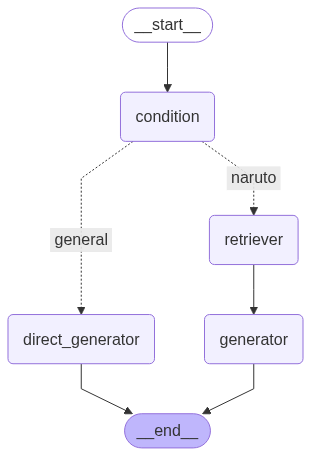

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [35]:
print("開始對話吧（輸入 q 結束）")

while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    init_state: RAGState = {
        "query": user_input,
        "docs": [],
        "answer": ""
    }

    result = graph.invoke(init_state)
    raw_output = result["answer"]

    answer_text = raw_output.split("回答：")[-1].strip()
    print("回答：", answer_text)
    print("===" * 20, "\n")

開始對話吧（輸入 q 結束）
使用者: 誰是第四代火影？
route: cosine_sim = 0.7063
跑到 → naruto
回答： 第四代火影是波風湊。

使用者: 第四代火影師父是誰?
route: cosine_sim = 0.7162
跑到 → naruto
回答： 第四代火影師父是自來也。

使用者: 第四代火影的徒弟有哪些人?
route: cosine_sim = 0.7476
跑到 → naruto
回答： 第四代火影波風湊的徒弟有旗木卡卡西、宇智波帶土、野原琳。

使用者: 誰發明了相對論?
route: cosine_sim = 0.3623
跑到 → general
回答： 相對論是由愛因斯坦（Albert Einstein）在 1905 年所發明的。

使用者: q
掰啦！


# advance

改成能支援多輪問答（Multi-turn RAG），並能根據前面的query判斷問題。

> 請將 RAGState 加入 history 欄位，並在生成回答時，將歷史對話與當前問題一起組成 prompt。

> Hint：
```
class MultiTurnRAGState(TypedDict):  
    history: List[str]  
    query: str  
    docs: List[Document]  
    answer: str
```



In [1]:
!pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.6 MB/s eta 0:00

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/911k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/508M [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [36]:
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

docs_text = """
火影代數	姓名	師傅	徒弟
初代	千手柱間	無明確記載	猿飛日斬、水戶門炎、轉寢小春
二代	千手扉間	千手柱間（兄長）	猿飛日斬、志村團藏、宇智波鏡等
三代	猿飛日斬	千手柱間、千手扉間	自來也、大蛇丸、千手綱手（傳說三忍）
四代	波風湊	自來也	旗木卡卡西、宇智波帶土、野原琳
五代	千手綱手	猿飛日斬	春野櫻、志乃等（主要為春野櫻）
六代	旗木卡卡西	波風湊	漩渦鳴人、宇智波佐助、春野櫻（第七班）
七代	漩渦鳴人	自來也、旗木卡卡西	木葉丸等（主要為木葉丸）
"""

docs = [Document(page_content=txt.strip()) for txt in docs_text.strip().split("\n\n")]

embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embedding_model,
    persist_directory="document_store",
    collection_name="naruto_collection",
    collection_metadata={"hnsw:space": "cosine"}
)
vectorstore.persist()

Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
from typing import TypedDict, List
class MultiTurnRAGState(TypedDict):
    history: List[str]
    query: str
    docs: List[Document]
    answer: str

In [38]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

from typing_extensions import TypedDict, List

# 定義 LangGraph 的 State 結構
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    answer: str

Device set to use cuda:0


In [39]:
def build_combined_query(state: MultiTurnRAGState, max_turns: int = 3) -> str:
    pronouns = ["他", "她", "的", "是誰", "哪些人"]
    query = state["query"]
    history = state.get("history", [])
    needs_context = any(word in query for word in pronouns)

    if needs_context and history:
        return "\n".join(history[-max_turns:] + [query])
    else:
        return query


In [50]:
def retrieve_node(state: MultiTurnRAGState) -> MultiTurnRAGState:
    combined_query = build_combined_query(state)
    docs = vectorstore.similarity_search(combined_query, k=3)
    return {
        "history": state["history"],
        "query": state["query"],
        "docs": docs,
        "answer": ""
    }

def generate_node(state: MultiTurnRAGState) -> MultiTurnRAGState:
    query, docs, history = state["query"], state["docs"], state["history"]
    context = "\n".join([d.page_content for d in docs])
    history_block = "\n".join(history)

    prompt = (
        f"你是一個知識型助手，請根據以下內容回答問題：\n\n"
        f"資料：\n{context}\n\n"
        f"歷史對話：\n{history_block}\n\n"
        f"當前問題：\n{query}\n\n回答："
    )
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {
        "history": history,
        "query": query,
        "docs": docs,
        "answer": output.strip()
    }

def direct_generate_node(state: MultiTurnRAGState) -> MultiTurnRAGState:
    query = state["query"]
    prompt = f"請回答以下問題：{query}\n\n回答："
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {
        "history": state["history"],
        "query": query,
        "docs": [],
        "answer": output.strip()
    }


def convert_to_cosine_distance(similarity: float, metric: str = "cosine") -> float:
    """
    將 cosine similarity 轉換為距離。

    - 若 metric 為 "cosine"，則 distance = 1 - similarity
    - 若 metric 為 "l2"，則 distance = sqrt(2 * (1 - similarity))
    """
    if metric == "cosine":
        return 1 - similarity
    elif metric == "l2":
        return (2 * (1 - similarity)) ** 0.5
    else:
        raise ValueError(f"Unsupported metric type: {metric}")



def route_by_query(state: MultiTurnRAGState):
    combined_query = build_combined_query(state)
    threshold = 0.4
    distance_metric = "cosine"

    scored_docs = vectorstore.similarity_search_with_score(combined_query, k=3)

    if scored_docs:
        similarities = [1 - score for _, score in scored_docs]
        distances = [convert_to_cosine_distance(sim, metric=distance_metric) for sim in similarities]
        min_distance = min(distances)

        print(f"route: cosine_distance = {min_distance:.4f}")
        if min_distance < threshold:
            print("跑到 → naruto")
            return "naruto"
        else:
            print("跑到 → general")
            return "general"
    else:
        print("route: 無檢索結果，改為 general")
        return "general"


In [51]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END

# 建立 LangGraph 流程圖
graph_builder = StateGraph(MultiTurnRAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

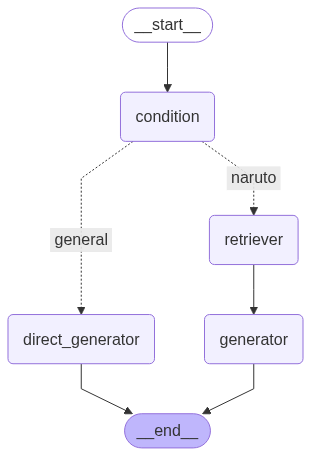

In [52]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [53]:
global_history: List[str] = []

print("開始對話吧（輸入 q 結束）")
while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    state = {"history": global_history, "query": user_input}
    result = graph.invoke(state)

    answer = result["answer"].split("回答：")[-1].strip()
    print("AI 助理:", answer)
    print("===" * 60, "\n")

    global_history = result["history"]
    global_history.append(result["answer"])

開始對話吧（輸入 q 結束）
使用者: 第四代火影是誰?
route: cosine_distance = 0.3088
跑到 → naruto
AI 助理: 第四代火影是波風湊。

使用者: 他的師父是誰?
route: cosine_distance = 0.2706
跑到 → naruto
AI 助理: 他的師父是自來也。

使用者: 他的徒弟有哪些人?
route: cosine_distance = 0.2262
跑到 → naruto
AI 助理: 他的徒弟有旗木卡卡西、宇智波帶土、野原琳。

使用者: 相對論是他發明的嗎?


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


route: cosine_distance = 0.2704
跑到 → naruto
AI 助理: 相對論不是波風湊發明的，而是由愛因斯坦（Albert Einstein）在1905年提出的。相對論是一種理論，主要描述重力、時間和空間的關係，以及物體在不同速度下所經歷的時間和空間。

使用者: q
掰啦！
